In [ ]:
from pyomo.environ import *
import csv
from math import radians, cos, sin, asin, sqrt

class Caso1:
    
    def __init__(self):
        self.model = ConcreteModel()
        self.idClientList=[]
        self.locationIdList=[]
        self.demands={}
        self.distances=None
        self.capacitys={}
        self.ranges={}
        self.depotId=None
        self.numNodes=None
        self.vehiclesIdList=[]
        
    
    def dataUpload(self):
        
        longitudeList=[]
        latitudeList=[]
        
        with open("data/depots.csv", newline='') as archivo_csv:
            lector = csv.reader(archivo_csv)
            next(lector)
            for fila in lector:
                self.locationIdList.append(int(fila[0]))
                self.depotId=int(fila[0])
                longitudeList.append(fila[1])
                latitudeList.append(fila[2])
        
        with open("data/clients15.csv", newline='') as archivo_csv:
            lector = csv.reader(archivo_csv)
            next(lector)
            for fila in lector:
                self.idClientList.append(fila[0])
                self.locationIdList.append(int(fila[1]))
                self.demands[int(fila[1])]=int(fila[2])
                longitudeList.append(fila[3])
                latitudeList.append(fila[4])
                
        with open("data/vehicles.csv", newline='') as archivo_csv:
            lector = csv.reader(archivo_csv)
            next(lector)
            for fila in lector:
                self.vehiclesIdList.append(int(fila[0]))
                self.capacitys[int(fila[0])]=int(fila[1])
                self.ranges[int(fila[0])]=int(fila[2])
                
        self.numNodes=len(self.locationIdList)
        self.preprocessData(longitudeList,latitudeList)
        
    
    def preprocessData(self,longitudeList,latitudeList):
        distance={}
        for i in range(len(longitudeList)):
            for j in range(len(longitudeList)):
                if i!=j:
                    distance[((self.locationIdList[i]),(self.locationIdList[j]))]=(self.calculateDistance(float(longitudeList[i]),float(latitudeList[i]),float(longitudeList[j]),float(latitudeList[j])))
                else:
                    distance[((self.locationIdList[i]),(self.locationIdList[j]))]=999
        self.distances=distance
    
    def calculateDistance(self,longitude1,latitude1,longitude2,latitude2):
        R=6371 # Radio de la Tierra en km
        lat1,lat2,lon1,lon2 = map(radians, [latitude1, latitude2, longitude1, longitude2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        distance =R* 2 * asin(sqrt(a))
        return round(distance,4)
    
    def createModel(self,maintingCost,consumptionCost):
        #Conjunto de nodos
        self.model.V=Set(initialize=self.locationIdList)
        # Conjunto de clientes
        self.model.v=Set(initialize=self.idClientList)
        # Conjunto de vehiculos
        self.model.K=Set(initialize=self.vehiclesIdList)
        
        #Distancia entre nodos
        self.model.d=Param(self.model.V,self.model.V,initialize=self.distances)
        
        # Demanda de los vehiculos
        self.model.q=Param(self.model.V,initialize=self.demands)
        
        # Rango del vehiculo
        self.model.R =Param(self.model.K,initialize=self.ranges)
        
        # Capacidad de los vehiculos
        self.model.Q =Param(self.model.K,initialize=self.capacitys)
        
        #Big M
        self.model.M=Param(initialize=1000)
        
        #Variable de decision
        self.model.x=Var(self.model.V,self.model.V,self.model.K,within=Binary,initialize=0)
        self.model.u=Var(self.model.V,within=NonNegativeReals )
        self.model.g=Var(self.model.V,self.model.K,within=NonNegativeReals)
        self.model.y=Var(self.model.V,self.model.K ,within=NonNegativeReals)
        
        
        #Funcion Objetivo
        self.model.Obj =Objective(expr=sum((self.model.d[i,j]*self.model.x[i,j,k])*(consumptionCost+maintingCost) for i in self.model.V for j in self.model.V for k in self.model.K),sense=minimize)
        

        #Restriccion 1: Cada cliente es visitado al menos una vez
        def visitOnce(model,i):
            if(i!=self.depotId):
                return sum(model.x[i,j,k] for k in model.K for j in model.V) == 1
            else:
                return Constraint.Skip
        self.model.visitOnce=Constraint(self.model.V,rule=visitOnce)
        
        #Restriccion 2: Continuidad de la ruta (Lo que entra sale)
        def routeConservation(model,i,k):
            return sum(model.x[j,i,k] for j in model.V) - sum(model.x[i,j,k] for j in model.V) == 0
        self.model.routeConservation=Constraint(self.model.V,self.model.K,rule=routeConservation)
        
        #Restriccion 3 Carga acumulada del origen al origen: 
        def loadFromOriginToOrigin(model,k):
            return model.g[self.depotId,k] == 0
        self.model.loadFromOriginToOrigin=Constraint(self.model.K,rule=loadFromOriginToOrigin)
        
        #Restriccion 4: Carga acumulada de un vehiculo
        def loadAccumulated(model,i,j,k):
            if(i!=self.depotId and j!=self.depotId):
                return model.g[i,k] >= model.g[j,k] + model.y[j,k] - model.M*(1-model.x[i,j,k])
            else:
                return Constraint.Skip
        self.model.loadAccumulated=Constraint(self.model.V,self.model.V,self.model.K,rule=loadAccumulated)
        #Restriccion 5: Capacidad de los vehiculos
        def maxCapacityVehicles(model,k):
            return sum(model.g[i,k] for i in model.V if i!= self.depotId) <= model.Q[k]
            
        self.model.maxCapacityVehicles=Constraint(self.model.K,rule=maxCapacityVehicles)
        
        
        
        #Restriccion 6: Demanda de cliente debe ser satisfecha
        def demandSatisfaction(model,i):
            if(i!=self.depotId):
                return sum(model.g[i,k] for k in model.K) == model.q[i]
            else:
                return Constraint.Skip
        self.model.demandSatisfaction=Constraint(self.model.V,rule=demandSatisfaction)
        
        
        #Restriccion 8: No puede self loops
        def noSelfLoops(Model,i,k):
            return Model.x[i,i,k] == 0
        self.model.noSelfLoops=Constraint(self.model.V,self.model.K,rule=noSelfLoops)
        #Restriccion 9: Eliminacion de subtours
        def subtour_elimination(model, i, j):
            if i != self.depotId and j != self.depotId and i != j:
                return model.u[i] - model.u[j] + (self.numNodes - 1) * sum(model.x[i,j,k] for k in model.K) <= self.numNodes - 2
            else:
                return Constraint.Skip
        self.model.subtour_elimination = Constraint(self.model.V, self.model.V, rule=subtour_elimination)
        
        def activateXWhenGPositive(model, i, k):
            if i != self.depotId:
                return model.g[i,k] <= self.model.M * sum(model.x[j,i,k] for j in model.V)
            else:
                return Constraint.Skip
        self.model.activateXWhenGPositive = Constraint(self.model.V, self.model.K, rule=activateXWhenGPositive)
        """
        #Restriccion 10: Deben salir del deposito el numero de vehiculos
        def depotExitVehicles(model,k):
            return sum(model.x[self.depotId,j,k] for j in model.V) == 1
        self.model.depotExitVehicles=Constraint(self.model.K,rule=depotExitVehicles)
        #Resitriccion 11: Deben entrar al deposito el numero de vehiculos
        def depotEnterVehicles(model,k):
            return sum(model.x[i,self.depotId,k] for i in model.V) == 1
        self.model.depotEnterVehicles=Constraint(self.model.K,rule=depotEnterVehicles)
        """
    
    def verificar_demanda_satisfecha(self):
        print("\n Detalle de entrega por vehículo:\n")
        for k in self.model.K:
            print(f"Vehículo {k}:")
            for i in self.model.V:
                if i == self.depotId:
                    continue
                cantidad = value(self.model.y[i, k])
                if cantidad > 0.01:
                    print(f"  → Entrega al cliente {i}: {cantidad:.1f} kg")
        
    def solve(self):
        solver = SolverFactory('gurobi', tee=True)
        
        #solver.options['msg'] = True
        #solver.options['output'] = True

        results = solver.solve(self.model)
        print("Termination condition:", results.solver.termination_condition) 
        if results.solver.status == SolverStatus.ok:
            print("Solver encontró una solución exitosa.")
        else:
            print(f"Estado del solver: {results.solver.status}")
        
        # Verificar valores de las variables después de la resolución
        
        
        print(value(self.model.Obj))
        print("\n--- Demanda total atendida por cada vehículo ---")
        for k in self.model.K:
            total_demand = 0
            for i in self.model.V:
                if i != self.depotId:  # evitamos contar el depósito
                    g_value = value(self.model.g[i, k])
                    if g_value is not None:
                        total_demand += g_value
            print(f"Vehículo {k}: {total_demand} unidades de demanda")
            
  
    def show(self):
        import matplotlib.pyplot as plt
        import networkx as nx

        G = nx.DiGraph()
        G.add_nodes_from(self.model.V)

        # Colores asignados a los vehículos
        color_map = {k: c for k, c in zip(self.model.K, ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'brown', 'cyan'])}
        edges_by_k = {}

        for i in self.model.V:
            for j in self.model.V:
                for k in self.model.K:
                    if value(self.model.x[i, j, k]) == 1:
                        edges_by_k.setdefault(k, []).append((i, j))

        pos = nx.spring_layout(G, k=5, iterations=200)

        # Crear la figura más grande
        plt.figure(figsize=(9, 6))

        # Dibujar nodos y etiquetas
        nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=300)
        nx.draw_networkx_labels(G, pos, font_size=9)

        # Dibujar aristas por vehículo con color y etiqueta
        for k in sorted(edges_by_k):  # Ordenar vehículos por ID
            nx.draw_networkx_edges(
                G, pos, edgelist=edges_by_k[k],
                edge_color=color_map.get(k, 'black'),
                width=2, arrows=True, arrowsize=10,
                label=f"Vehículo {k}"
            )

        # Crear leyenda ordenada
        import matplotlib.patches as mpatches
        legend_handles = [mpatches.Patch(color=color_map[k], label=f"Vehículo {k}") for k in sorted(edges_by_k)]
        plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.title("Mapa de Rutas por Vehículo", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        
        
    def generar_verificacion(self):
        with open("verificacion_caso1.csv", "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["VehicleId", "VehicleType", "InitialLoad", "RouteSequence",
                            "ClientsServed", "DemandSatisfied", "TotalDistance", "Cost"])
            
            for k in self.model.K:
                route = ["CD"]
                demand_list = []
                total_distance = 0
                init_load = 0
                for i in self.model.V:
                    for j in self.model.V:
                        if value(self.model.x[i, j, k]) == 1:
                            if j != self.depotId:
                                route.append(f"COM{j:02d}")
                                demand = int(value(self.model.g[j, k]))
                                demand_list.append(demand)
                                total_distance += value(self.model.d[i, j])
                                init_load += demand
                route.append("CD")
                writer.writerow([
                    int(k),
                    "Truck",  # o "Drone" si aplicara
                    init_load,
                    " - ".join(route),
                    len(demand_list),
                    "-".join(map(str, demand_list)),
                    round(total_distance, 2),
                    round(total_distance * 1000, 2)  # ajusta el costo por km
                ])
        


In [7]:
c_m =0.01
c_c=0.10
caso1 = Caso1()
caso1.dataUpload()
caso1.createModel(maintingCost=c_m,consumptionCost=c_c)
caso1.solve()


Termination condition: optimal
Solver encontró una solución exitosa.
17.160957

--- Demanda total atendida por cada vehículo ---
Vehículo 1: 0.0 unidades de demanda
Vehículo 2: 56.0 unidades de demanda
Vehículo 3: 57.0 unidades de demanda
Vehículo 4: 0.0 unidades de demanda
Vehículo 5: 58.0 unidades de demanda
Vehículo 6: 60.0 unidades de demanda
Vehículo 7: 0.0 unidades de demanda
Vehículo 8: 15.0 unidades de demanda


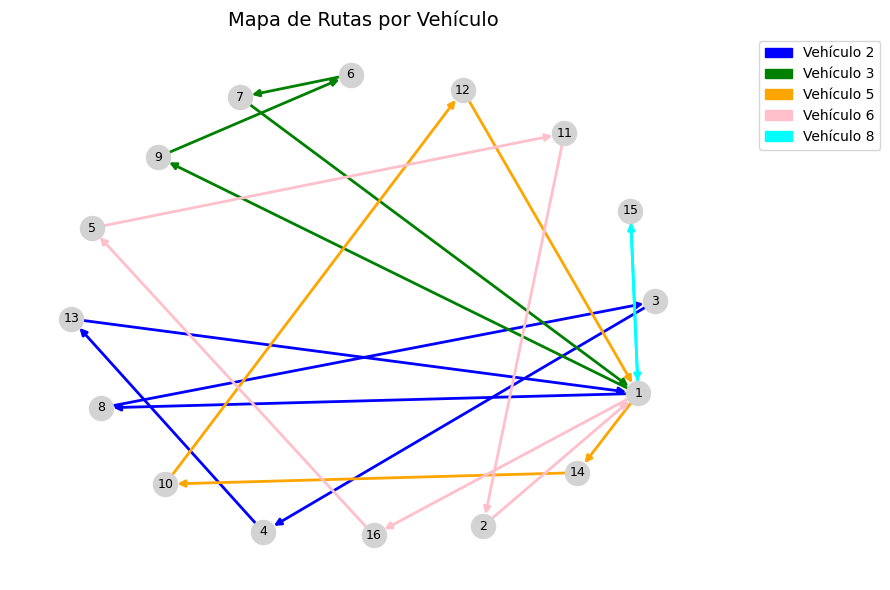

In [8]:
caso1.show()

In [9]:
caso1.generar_verificacion()

### Diagrama de gantt

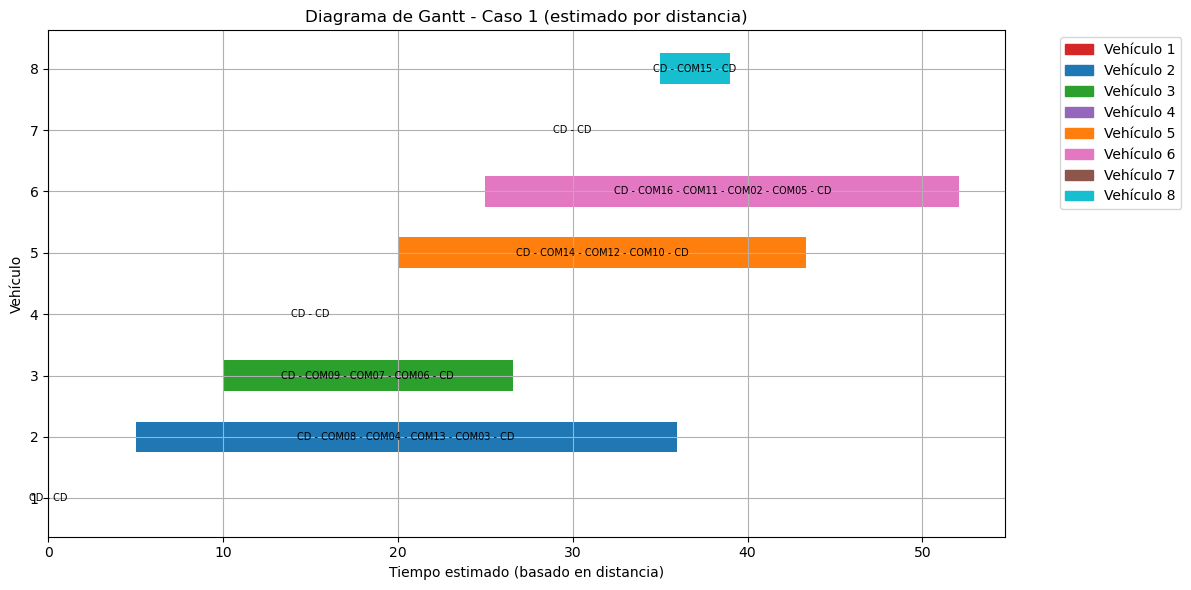

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cargar el archivo CSV
df = pd.read_csv('verificacion_caso1.csv')

# Crear figura
fig, ax = plt.subplots(figsize=(12, 6))
start_time = 0
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange', 'tab:pink', 'tab:brown', 'tab:cyan']
patches = []

# Dibujar barras por vehículo
for idx, row in df.iterrows():
    duration = row['TotalDistance']
    vehicle = row['VehicleId']
    route = row['RouteSequence']
    color = colors[idx % len(colors)]

    ax.barh(y=vehicle, width=duration, left=start_time, height=0.5, color=color)
    ax.text(start_time + duration / 2, vehicle, f"{route}", va='center', ha='center', fontsize=7)
    patches.append(mpatches.Patch(color=color, label=f"Vehículo {vehicle}"))
    start_time += 5  # Separación entre barras

# Etiquetas
ax.set_xlabel("Tiempo estimado (basado en distancia)")
ax.set_ylabel("Vehículo")
ax.set_title("Diagrama de Gantt - Caso 1 (estimado por distancia)")
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
